In [1]:
#from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, quantum_info, execute, transpile, assemble, IBMQ
#from qiskit.circuit import Gate
#from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
#from qiskit.quantum_info import Statevector,random_statevector
#from qiskit.extensions import Initialize
#from qiskit.tools.monitor import job_monitor
#from qiskit.visualization import array_to_latex
#from qiskit.providers.ibmq import least_busy

from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.extensions import *
from qiskit.tools.monitor import *
from qiskit.providers.ibmq import *
from qiskit.circuit import *

import numpy as np
import matplotlib as mpl

from ipywidgets import interactive
from IPython.core.display import display

#%config InlineBackend.figure_format = 'retina' #si tenéis pantalla retina (creo que más de 144ppp)las figuras salen
#con mejor definición con este comando. Si no teneis, usad el comando de abajo pero va a cambiar el tamaño de todo.
mpl.rcParams['figure.dpi'] = 50 

Todos los índices van de $0$ a $n-1$ o $N-1$, con $N=2^n$ si no explicita nada (siendo $n$ el número de qbits).

# QFT (Quantum Fourier Transform) 

## DFT:

$$
\vec{y} = \operatorname{DFT} \left[ \vec{x} \right] \qquad \vec{y} = y^k \lvert k \rangle \qquad \vec{x} = x^j \lvert j \rangle
$$

$$
y_k = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \left[ \omega_N \right]_{j}^{k} x^j \quad \text{ con }
\left[ \omega_N \right]_{j}^{k} = \left[ e^{2\pi i\frac{jk}{N}} \right]_{j}^{k}  = \begin{bmatrix}
1&1&1&1&\cdots &1 \\
1&\omega_N&\omega_N^2&\omega_N^3&\cdots&\omega_N^{N-1} \\
1&\omega_N^2&\omega_N^4&\omega_N^6&\cdots&\omega_N^{2(N-1)}\\ 1&\omega_N^3&\omega_N^6&\omega_N^9&\cdots&\omega_N^{3(N-1)}\\
\vdots&\vdots&\vdots&\vdots&\ddots&\vdots\\
1&\omega_N^{N-1}&\omega_N^{2(N-1)}&\omega_N^{3(N-1)}&\cdots&\omega_N^{(N-1)(N-1)}
\end{bmatrix}
$$

## QFT: Descripción téorica

$$|X\rangle = \sum_{j=0}^{N-1}x^j \lvert j\rangle \equiv x^j \lvert j\rangle \qquad \text{ con } N=2^n \text{ estados accesibles }(n \text{ cúbits})$$

$$
|Y\rangle = \operatorname{U_{QFT}}|X\rangle = \sum_{k=0}^{N-1}y^k \lvert k\rangle \equiv y^k \lvert k\rangle, \qquad \text{ donde } \
\operatorname{U_{QFT}} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1}\left[ \omega_N \right]_{j}^{k}  \vert k \rangle \langle j \vert.
$$

Nota: $x^l,y^l \in \{0,1\} \ \forall 0 \geq l \geq (n-1) / N$

### Caso particular $ \lvert X \rangle = \lvert j \rangle$:

$$ \displaystyle \operatorname{U_{QFT}} \lvert j \rangle = 
\frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}\left[ \omega_N \right]_{j}^{k}  \vert k \rangle 
=\frac{1}{\sqrt{N}} \bigotimes_{l=0}^{n-1} \left\{ \lvert 0 \rangle + e^{\displaystyle i \frac{2 \pi}{2^n} j} \lvert 1 \rangle \right\} $$

### Expresión más general

$$ \displaystyle \operatorname{U_{QFT}} \lvert x  \rangle = 
\frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1}\left[ \omega_N \right]_{j}^{k} x^j \vert k \rangle =
\frac{1}{\sqrt{N}} \left\{ \sum_{j=0}^{N-1} x^j \left[ \bigotimes_{l=0}^{n-1} \left( \lvert 0 \rangle + e^{\displaystyle i \frac{2 \pi}{2^n} j} \lvert 1 \rangle \right) \right] \right\} =
\sum_{j=0}^{N-1} x^j \operatorname{U_{QFT}} \lvert j \rangle, \qquad \lvert x\rangle = x^j \lvert j\rangle $$

Esto nos da una idea de las 2 bases que hay en juego $\mathcal{B}_{z}=\left\{ \lvert j \rangle \right\}_{j=0}^{N-1}$ y $\mathcal{B}_{\operatorname{U_{QFT}}}=\left\{ \operatorname{U_{QFT}} \lvert j \rangle \right\}_{j=0}^{N-1}$.

# Implementación de QFT:

<img src="Imagenes_repaso/QFT.png"/>

Aplicar las sucesivas puertas sobre el qbit $\lvert x_{n-1} \rangle$, da lugar a $\lvert \tilde{x}_{n-1} \rangle$

Partiendo de un estado $|x\rangle = |x_{n-1}\dots x_1x_0\rangle$, el circuito opera de la siguiente forma:
1. Añadimos una puerta de Hadamard a nuestro primer cúbit. 
$$
\begin{aligned}\\
H_{n-1}|x_{n-1}\dots x_1x_0\rangle = \frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(\frac{2\pi i}{2}x_{n-1}\right)|1\rangle\right] \otimes |x_{n-2}\dots x_1x_0\rangle
\end{aligned}
$$

2. Aplicamos las sucesivas puertas $R_k$ que afectan al primer cúbit, donde obtenemos 
$$
\begin{aligned}\\
\frac{1}{\sqrt{2}}&\left[|0\rangle + \exp\left(\frac{2\pi i}{2^n}x_0 + \frac{2\pi i}{2^{n-1}}x_1 + \dots + \frac{2\pi i}{2}x_{n-1}\right)|1\rangle\right] \otimes |x_{n-2}\dots x_1x_0\rangle \\
&= \frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(\frac{2\pi i}{2^n}x\right)|1\rangle\right] \otimes |x_{n-2}\dots x_1x_0\rangle,\\\\
\end{aligned}
$$
donde empleamos que $x = 2^{n-1}x_{n-1}+\dots+2^1x_1+2^0x_0$, es la $\textbf{representación decimal}$ del estado $\lvert x_{n-1} \dots x_0 \rangle$; i.e, $\lvert x \rangle \equiv \lvert x_{n-1} \dots x_0 \rangle$

3. Repetimos el mismo proceso para el resto de cúbits, donde obtenemos finalmente 
$$
\begin{aligned}\\
\frac{1}{\sqrt{2}}&\left[|0\rangle + \exp\left(\frac{2\pi i}{2^n}x \right)|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(\frac{2\pi i}{2^{n-1}}x \right)|1\rangle\right]
\otimes
\dots \\
&\qquad\otimes
\frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(\frac{2\pi i}{2^{2}}x \right)|1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}\left[|0\rangle + \exp\left(\frac{2\pi i}{2^{1}}x \right)|1\rangle\right] \\
&= \frac{1}{2^{\frac{n}{2}}} \bigotimes_{k=1}^n  \left(|0\rangle + e^{\displaystyle i \left( \frac{2 \pi }{2^{n+1-k}}x \right)} |1\rangle \right).
\end{aligned}
$$

4. Invertimos el orden de los cúbits dado que nuestro resultado final no es más que la aplicación de la QFT a nuestra entrada pero con el orden de los cúbits invertido, tal que $n+1-k \rightarrow k$.
Veamos de una forma más clara el porqué del uso de *swaps* analizando el cambio que produce en el índice $k$.

\begin{array}{c|c}
  k & n+1-k \\\hline
  1 & n \\
  2 & n-1 \\
  \vdots & \vdots \\
  n-1 & 2 \\
  n & 1 \\
\end{array}

## Circuito QFT:

Definimos la puerta controlada de rotación  $CR_k$  

In [2]:
def cr_k(k: int) -> Gate:
    """Definición de la puerta CR_k."""
    qc = QuantumCircuit(1)
    qc.p(2*np.pi/2**k, 0)
    
    gate = qc.to_gate()
    gate.label = 'R$_{%i}$' % (k)
    return gate.control()
    qc.draw('mpl')

### Circuito generalizado:

In [3]:
def qft(circuit: QuantumCircuit, n: int) -> QuantumCircuit:
    """QFT para n cúbits."""
    # Si n=0, devolvemos el circuito introducido
    if n == 0:
        return circuit
    n -=1
    for block in range(n):
        circuit.h(n-block)
        for qbit in range(n-block):
            circuit.append(cr_k(n-block-qbit+1), [qbit, n-block])
    circuit.h(0)
    
    #Swap
    n += 1
    for qbit in range(n//2):
            circuit.swap(qbit,n-qbit-1)
    return circuit

In [4]:
def scale_qft(n: int) -> None:
    """Visualización interactiva de la QFT a n cúbits."""
    qft_circ = qft(QuantumCircuit(n), n)
    display(qft_circ.draw(output='mpl', plot_barriers=False))

In [5]:
def inverse_qft(circuit: QuantumCircuit, n: int) -> QuantumCircuit:
    """Inversa de la QFT para n cúbits."""
    # Creamos un circuito de n cúbits y aplicamos la QFT
    qft_circ = qft(QuantumCircuit(n), n)
    # Invertimos el ciruito
    invqft_circ = qft_circ.inverse()
    # Añadimos este último circuito al circuito original
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose()  # .decompose() nos permite ver cada puerta

### Ejemplo

In [16]:
qc = qft(QuantumCircuit(6),n=6)
qc.draw(fold=-1,output='mpl')
U=Operator(qc).data

In [17]:
qc = inverse_qft(qc,n=6)
qc.draw(output='mpl')
V=Operator(qc).data

In [18]:
import numpy as np
np.round(np.matmul(U,V),2)

array([[0.12+0.j  , 0.12-0.j  , 0.12-0.j  , ..., 0.12-0.j  , 0.12-0.j  ,
        0.12-0.j  ],
       [0.12+0.j  , 0.12+0.01j, 0.12+0.02j, ..., 0.12-0.04j, 0.12-0.02j,
        0.12-0.01j],
       [0.12+0.j  , 0.12+0.02j, 0.12+0.05j, ..., 0.1 -0.07j, 0.12-0.05j,
        0.12-0.02j],
       ...,
       [0.12+0.j  , 0.12-0.04j, 0.1 -0.07j, ..., 0.08+0.1j , 0.1 +0.07j,
        0.12+0.04j],
       [0.12+0.j  , 0.12-0.02j, 0.12-0.05j, ..., 0.1 +0.07j, 0.12+0.05j,
        0.12+0.02j],
       [0.12+0.j  , 0.12-0.01j, 0.12-0.02j, ..., 0.12+0.04j, 0.12+0.02j,
        0.12+0.01j]])

In [11]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.extensions import *
from qiskit.tools.monitor import *
from qiskit.providers.ibmq import *
from qiskit.circuit import *
from qiskit.circuit.library import*

In [12]:
def opQFT(n: int,b=False):
    ini_cir = QuantumCircuit(n)
    ini_cir.compose(QFT(num_qubits=n, approximation_degree=0,
               do_swaps=True, inverse=b, insert_barriers=True,
               name='qft'),qubits=range(n),inplace=True)
    return Operator(ini_cir).data
opQFT(6)

array([[0.125     +0.j        , 0.125     +0.j        ,
        0.125     +0.j        , ..., 0.125     +0.j        ,
        0.125     +0.j        , 0.125     +0.j        ],
       [0.125     +0.j        , 0.12439809+0.01225214j,
        0.12259816+0.02438629j, ..., 0.11961754-0.03628558j,
        0.12259816-0.02438629j, 0.12439809-0.01225214j],
       [0.125     +0.j        , 0.12259816+0.02438629j,
        0.11548494+0.04783543j, ..., 0.1039337 -0.06944628j,
        0.11548494-0.04783543j, 0.12259816-0.02438629j],
       ...,
       [0.125     +0.j        , 0.11961754-0.03628558j,
        0.1039337 -0.06944628j, ..., 0.07929916+0.09662631j,
        0.1039337 +0.06944628j, 0.11961754+0.03628558j],
       [0.125     +0.j        , 0.12259816-0.02438629j,
        0.11548494-0.04783543j, ..., 0.1039337 +0.06944628j,
        0.11548494+0.04783543j, 0.12259816+0.02438629j],
       [0.125     +0.j        , 0.12439809-0.01225214j,
        0.12259816-0.02438629j, ..., 0.11961754+0.03628558j,
 

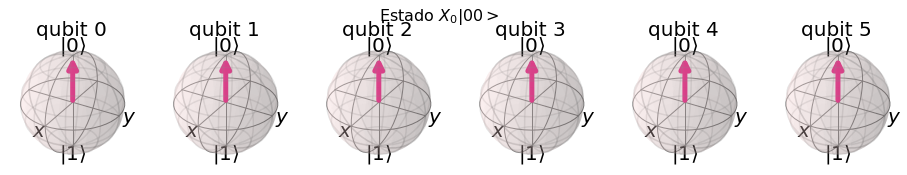

In [8]:
# Obtenemos un estado a partir de su representación binaria
state = Statevector.from_label('000000')
# Lo visualizamos
plot_bloch_multivector(state, title='Estado $|00>$')
new_state = state.evolve(qc)
plot_bloch_multivector(new_state, title='Estado $X_0|00>$')